In [1]:
%run libreria.py
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import utm
import pandas as pd
import math
from matplotlib.pyplot import figure
from matplotlib import cm as CM
from matplotlib import mlab as ML
import pymysql

def distancia_genetica_corregida(a, b, distribution, N_mam=269):
    P_A1_a1=1
    P_A2_a2=1
    P_A2_a2_hermano_a2=1
    for alele in distribution:
        P_A1_a1=P_A1_a1*(distribution[alele][a[alele]])
        P_A2_a2=P_A2_a2*(distribution[alele][b[alele]])
        # La probabilidad abajo es: si son iguales, es 1/2 (si vino de la misma columna alelo) + (1/2)*prob_del_alelo si vino de distinta columna, pero si 
        # son distintos son 1/2 * probabilidad de ese alelo. 
        P_A2_a2_hermano_a2=P_A2_a2_hermano_a2*((1/2)*int(a[alele]==b[alele])+(1/2)*distribution[alele][b[alele]])
    P_A1_A2_distinta_mama=P_A1_a1*P_A2_a2
    P_A1_A2_misma_mama=P_A1_a1*P_A2_a2_hermano_a2
    return (1/(1+(N_mam-1)*P_A1_A2_distinta_mama/P_A1_A2_misma_mama))
    
def get_connection():
    return pymysql.connect(host='ec2-3-16-15-72.us-east-2.compute.amazonaws.com',
                             user='root',
                             password='password',
                             db='dbname',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)
        
    

In [2]:
locations, coordenadas, distance_national_park=get_loc_coords_dnp()

xaxis  = [utm.from_latlon(coordenadas[l][0],coordenadas[l][1])[0]  for l in coordenadas]
yaxis = [utm.from_latlon(coordenadas[l][0],coordenadas[l][1])[1] for l in coordenadas]
medy  =  np.mean(yaxis)
medx  =  np.mean(xaxis)

xaxis  = [to_xy((coordenadas[l][0],coordenadas[l][1]))[0]  for l in coordenadas]
yaxis = [to_xy((coordenadas[l][0],coordenadas[l][1]))[1] for l in coordenadas]
medy2  =  np.mean(yaxis)
medx2  =  np.mean(xaxis)

information={}
for k in coordenadas:
    information[k]={}
    information[k]["coordenadas"]=coordenadas[k]
    utm_val=utm.from_latlon(coordenadas[k][0], coordenadas[k][1])
    information[k]["utm_xy"]=((utm_val[0]-medx)/1000, (utm_val[1]-medy)/1000)
    
    xy_val=to_xy(coordenadas[k])
    information[k]["alt_xy"]=((xy_val[0]-medx2)/1000, (xy_val[1]-medy2)/1000)
    
    information[k]["distance_np"]=distance_national_park[k]
    
    

In [4]:
f=open("output_colony.csv", "r")
a="A"
ind=0
familias=[]
while a!="":
    a=f.readline()
    if ind>0:
        nd={}
        b=a.split(",")
        if len(b)>2:
            nd["Familia"]=b[0]
            nd["c1"]=float(b[1])
            nd["c2"]=float(b[2])
            ind2=3
            parientes=[]
            while ind2<len(b):
                if b[ind2]!="" and b[ind2]!="\n": parientes.append(b[ind2].replace("\n", ""))
                ind2+=1
            nd["integrantes"]=parientes
            familias.append(nd)
    ind+=1

In [5]:
df=pd.read_csv("Aleles_clean.csv")
df["Site"]=[locations[i] for i in df["Collection site"]]
df_syd2018=df[df.Cluster=="PC2018"].copy()
df=pd.read_csv("Aleles_clean.csv")
df["Site"]=[locations[i] for i in df["Collection site"]]
df_syd2018=df[df.Cluster=="PC2018"].copy()

df_syd2018["Familia"]=[searchfam(i, familias)["Familia"] for i in df_syd2018["name0"]]
df_syd2018["C1_familia"]=[searchfam(i, familias)["c1"] for i in df_syd2018["name0"]]
df_syd2018["C2_familia"]=[searchfam(i, familias)["c2"] for i in df_syd2018["name0"]]

aleles=["Al1", "Al2", "Al3", "Al4", "Al5", "Al6", "Al7"]
distribution={}


other_coords=['Caringbah', 'Parramatta', 'Strickland']
urban_coords=["Marrickville", "Surry Hills", "Camperdown", "Asheville", "Balgowlah "]
rural_coords=["Jannali", "Sutherland", "Manley", "Lindfield", "Gordon", "Palmbeach", "Stives"]
    
coords2={}
coords2["all"]=other_coords+urban_coords+rural_coords
coords2["rural"]=rural_coords
coords2["urban"]=urban_coords


for uu in ["urban", "rural", "all"]:
    distribution[uu]={}
    for alele in aleles:
        tot=list(df_syd2018[[(i in coords2[uu]) for i in df_syd2018["Site"]]][alele])
        distribution[uu][alele]={}
        for a in tot:
            if a not in distribution[uu][alele]: 
                    distribution[uu][alele][a]=0
            distribution[uu][alele][a]+=1/float(len(tot))



In [6]:
import pickle

with open("all_families_all.pkl", "rb") as fil:
    distancias_genetica4, distancias_fisica=pickle.load(fil)

In [7]:
def final_plot(df_pares_abejas, dic_curva=None):
    f=figure(facecolor="white", edgecolor="black")
    f.set_facecolor('white')
    ax = f.add_subplot(1, 1, 1) # nrows, ncols, index
    ax.set_facecolor("white")
    ma1=5
    ma2=5
    if dic_curva==None:
        dic_curva={}

        for k in range(0, 101, 10):
            print(k, end="   \r")
            cropped=df_pares_abejas[(df_pares_abejas.Similitud_genetica_4>= (k-ma1)/100.0) & 
                                     (df_pares_abejas.Similitud_genetica_4< (k+ma1)/100.0)]
            leni=len(cropped)
            xs=[]
            ys=[]
            for s in range(0, 50):
                #cropped["d2"]=[i+random.normalvariate(0,1) for i in cropped["Distancia"]]
                l1=len(cropped[(cropped.Distancia < (s))])/leni
                xs.append(l1)
                ys.append(s)
            color=(k)/(100)
            c1="#1c92d2"
            c2="#f2fcfe"
            color=gradient(c1, c2, color)
            plt.plot(ys, xs, c=color, label="p ["+str(np.max([(k-ma1)/100.0, 0.0]))+", "+str(np.min([(k+ma1)/100.0, 1])) +")")
            dic_curva[k]=[ys, xs]
    else:
         for k in range(0, 101, 10):
            color=(k)/(100)
            c1="#1c92d2"
            c2="#f2fcfe"
            color=gradient(c1, c2, color)
            xs=dic_curva[k][1]
            ys=dic_curva[k][0]
            plt.plot(ys, xs, c=color, label="p ["+str(np.max([(k-ma1)/100.0, 0.0]))+", "+str(np.min([(k+ma1)/100.0, 1])) +")")
    plt.ylim([0,1])
    plt.legend()
    ax.set_xlabel("Kms between the sites where each pair now collected")
    ax.set_ylabel("Proportion of pairs")
    f.savefig("final_frequencies.pdf")
    plt.show()
    return dic_curva
            



In [8]:
dicton_final={}
for uu in ["urban", "rural", "all"]:
    dicton_final[uu]={}

urban


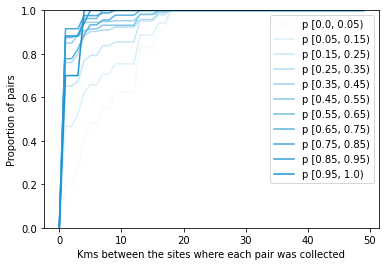

rural


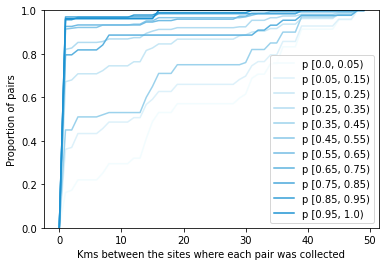

all


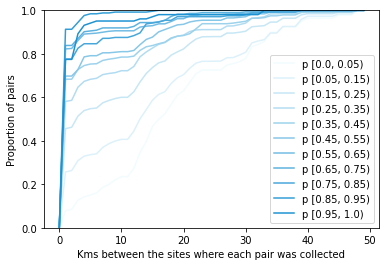

In [9]:
for uu in ["urban", "rural", "all"]:
    print(uu)
    df_pares_abejas=pd.DataFrame({"Distancia":distancias_fisica[uu],
                 "Similitud_genetica_4":distancias_genetica4[uu][300]})
    dicton_final[uu][300]=final_plot(df_pares_abejas)



Prior 100 families


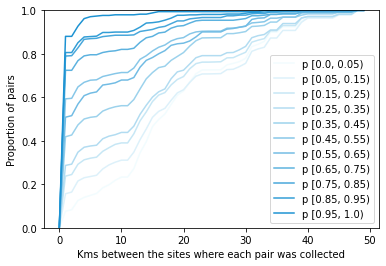

Prior 300 families


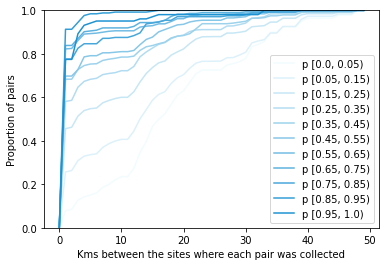

Prior 450 families


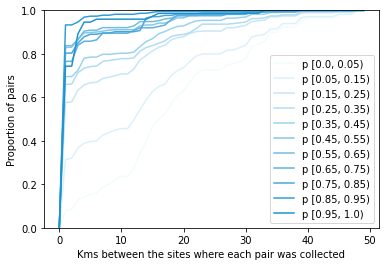

Prior 600 families


Prior 750 families


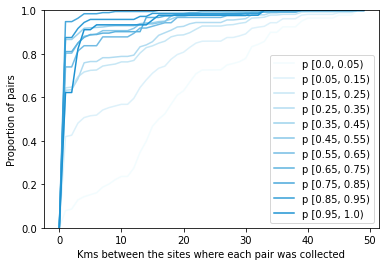

Prior 900 families


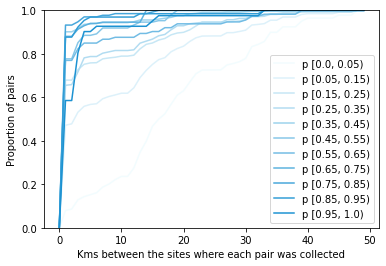

Prior 1500 families


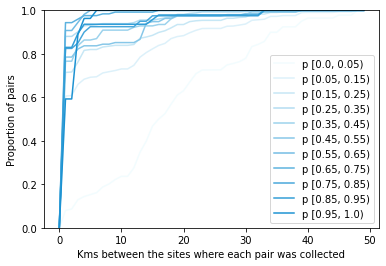

In [10]:
for kk in [100, 300, 450, 600, 750, 900, 1500]:
    uu="all"
    print("Prior "+str(kk)+" families")
    df_pares_abejas=pd.DataFrame({"Distancia":distancias_fisica[uu],
                 "Similitud_genetica_4":distancias_genetica4[uu][kk]})
    dicton_final[uu][kk]=final_plot(df_pares_abejas)

In [11]:
import time

## 2017

In [12]:
def get_2017(getdistribution=False):
    fams=[201, 380, 475, 570]
    coordenadas={ "Vegetable university":(-33.88923, 151.19259), "Marrickville 2":(-33.90468, 151.16067),
             'Bondi Junction': (-33.88877, 151.24145) , 'University': (-33.88514, 151.18837), 'Surrey Hills':(-33.88972, 151.20965),
             'Marrickville sp':(-33.89828, 151.16525), 
                 'Newtown': (-33.894944, 151.187083), 'Anandale': (-33.882977, 151.173809),
                 "Jannali":(-34.0212, 151.06618), 'Caringbah':(-34.06084, 151.11107),
                 'Marrickville':(-33.89828, 151.16525), "Leichhardt":(-33.884889, 151.156028),
                 "Paddington":(-33.881917, 151.180611), "Tanya":(-33.88425, 151.23336)
            }

    xaxis  = [utm.from_latlon(coordenadas[l][0],coordenadas[l][1])[0]  for l in coordenadas]
    yaxis = [utm.from_latlon(coordenadas[l][0],coordenadas[l][1])[1] for l in coordenadas]
    medy  =  np.mean(yaxis)
    medx  =  np.mean(xaxis)

    xaxis  = [to_xy((coordenadas[l][0],coordenadas[l][1]))[0]  for l in coordenadas]
    yaxis = [to_xy((coordenadas[l][0],coordenadas[l][1]))[1] for l in coordenadas]
    medy2  =  np.mean(yaxis)
    medx2  =  np.mean(xaxis)

    information={}
    for k in coordenadas:
        information[k]={}
        information[k]["coordenadas"]=coordenadas[k]
        utm_val=utm.from_latlon(coordenadas[k][0], coordenadas[k][1])
        information[k]["utm_xy"]=((utm_val[0]-medx)/1000, (utm_val[1]-medy)/1000)

        xy_val=to_xy(coordenadas[k])
        information[k]["alt_xy"]=((xy_val[0]-medx2)/1000, (xy_val[1]-medy2)/1000)




    df=pd.read_csv("Aleles_clean.csv")
    df["Site"]=[locations[i] for i in df["Collection site"]]
    df_syd2018=df[df.Cluster=="PC2017"].copy()

    aleles=["Al1", "Al2", "Al3", "Al4", "Al5", "Al6", "Al7"]
    distribution={}


   


    for uu in ["all"]:
        distribution[uu]={}
        for alele in aleles:
            tot=list(df_syd2018[alele])
            distribution[uu][alele]={}
            for a in tot:
                if a not in distribution[uu][alele]: 
                        distribution[uu][alele][a]=0
                distribution[uu][alele][a]+=1/float(len(tot))
    if getdistribution: return distribution
    
    distancias_fisica={}
    distancias_genetica4={}

    for uu in ["urban", "rural", "all"]:
        distancias_fisica[uu]=[]
        distancias_genetica4[uu]={}
        for nm in fams:
            distancias_genetica4[uu][nm]=[]

    start=time.time()
    i=0
    total=len(df_syd2018)
    for fam1 in df_syd2018.iterrows():
        i=i+1
        velocidad=i/(time.time()-start)
        quedan=total-i
        tiempo_restante=round((quedan/velocidad)/60.0)
        print(str(i)+"/"+str(total)+" Remaining time="+str(tiempo_restante)+" minutos", end="        \r")
        j=0
        for fam2 in df_syd2018.iterrows():
            j=j+1
            if j>i:
                distancias_fisica["all"].append(distancia_fisica(fam1[1]["Site"], fam2[1]["Site"], information))
                for nm in fams:
                    distancias_genetica4["all"][nm].append(distancia_genetica_corregida(fam1[1], fam2[1], distribution["all"], N_mam=nm))

    return distancias_genetica4, distancias_fisica
                

In [14]:
import pickle
if True:
    with open("2017-s.pkl", "rb") as fil:
        dg42017, df2017=pickle.load( fil)
else:    
    dg42017, df2017 = get_2017()

In [15]:
distribution2017= get_2017(True)


In [16]:
coordenadas2017={ "Vegetable university":(-33.88923, 151.19259), "Marrickville 2":(-33.90468, 151.16067),
             'Bondi Junction': (-33.88877, 151.24145) , 'University': (-33.88514, 151.18837), 'Surrey Hills':(-33.88972, 151.20965),
             'Marrickville sp':(-33.89828, 151.16525), 
                 'Newtown': (-33.894944, 151.187083), 'Anandale': (-33.882977, 151.173809),
                 "Jannali":(-34.0212, 151.06618), 'Caringbah':(-34.06084, 151.11107),
                 'Marrickville':(-33.89828, 151.16525), "Leichhardt":(-33.884889, 151.156028),
                 "Paddington":(-33.881917, 151.180611), "Tanya":(-33.88425, 151.23336)
            }

dict_nums={}
for d in range(0,100):
    dict_nums[d]=0
    
ii=0
for k in coordenadas2017:
    jj=0
    for u in coordenadas2017:
        if jj>=ii:
            l1=utm.from_latlon(coordenadas2017[k][0], coordenadas2017[k][1])
            l2=utm.from_latlon(coordenadas2017[u][0], coordenadas2017[u][1])
            
            dist=euclidean_dist((l1[0], l1[1]), (l2[0], l2[1]))/1000
            dict_nums[int(dist)]+=1
        jj+=1
    ii+=1

ii=0
for k in coordenadas:
    jj=0
    for u in coordenadas:
        if jj>=ii:
            l1=utm.from_latlon(coordenadas[k][0], coordenadas[k][1])
            l2=utm.from_latlon(coordenadas[u][0], coordenadas[u][1])
            
            dist=euclidean_dist((l1[0], l1[1]), (l2[0], l2[1]))/1000
            dict_nums[int(dist)]+=1
        jj+=1
    ii+=1


In [17]:
import matplotlib

matplotlib.rc('font',**{'family':'serif','serif':['Helvetica'], 'size':16})
plt.rcParams['pdf.fonttype'] = 42


Len gemels:162
Percentile 0
0.0
Percentile 5
0.0
Percentile 10
0.0
Percentile 15
0.0
Percentile 20
0.0
Percentile 25
0.0
Percentile 30
0.0
Percentile 35
0.0
Percentile 40
0.0
Percentile 45
0.0
Percentile 50
0.0
Percentile 55
0.0
Percentile 60
0.0
Percentile 65
0.0
Percentile 70
0.8266386597572106
Percentile 75
2.164502094752656
Percentile 80
2.7207476067284375
Percentile 85
3.355795473116945
Percentile 90
4.794049597361487
Percentile 95
7.084727186753151
0.9111111111111111
Len gemels:63
Percentile 0
0.0
Percentile 5
0.0
Percentile 10
0.0
Percentile 15
0.0
Percentile 20
0.0
Percentile 25
0.0
Percentile 30
0.0
Percentile 35
0.0
Percentile 40
0.0
Percentile 45
0.0
Percentile 50
0.0
Percentile 55
0.08266386597572224
Percentile 60
0.9359595355887136
Percentile 65
1.6106207556661163
Percentile 70
2.164502094752656
Percentile 75
2.164502094752656
Percentile 80
2.498249401938126
Percentile 85
3.3557954731169444
Percentile 90
4.597327481386819
Percentile 95
6.984954618224094
0.9206349206349206


/Users/Bernardo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/Bernardo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


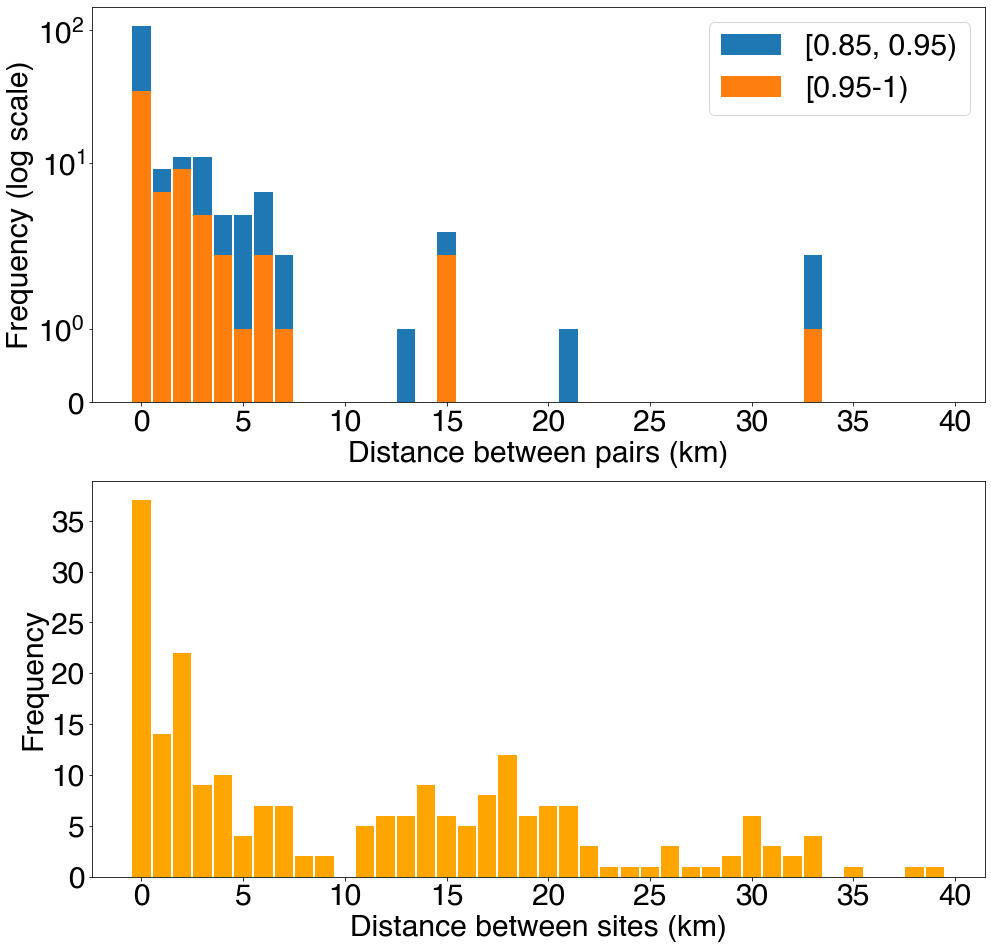

In [27]:
f=plt.figure(figsize=(16,16))
ax=plt.subplot(int(str("211")))    

tot6km=0
totot=0
for lb in [0.85, 0.95]:
    gemels=[]
    for a, b in zip(dg42017["all"][570], df2017["all"]):
        if a>=lb:
            gemels.append(b)
            totot+=1
            if b<6: tot6km+=1
            
    for a, b in zip(distancias_genetica4["all"][750], distancias_fisica["all"]):
        if a>=lb:
            gemels.append(b)

    dict_visitas={}
    for d in range(0,70):
        dict_visitas[d]=0

    for d in gemels:
            dict_visitas[int(round(d))]+=1

    print("Len gemels:"+str(len(gemels)))
    
    if lb==0.85: plt.bar([d for d in range(0, 40)], [dict_visitas[d] for d in range(0,40)],  width=0.9, label="[0.85, 0.95)")
    else: plt.bar([d for d in range(0, 40)], [dict_visitas[d] for d in range(0,40)],  width=0.9, label="[0.95-1)")

    for k in range(0,100,5):
        print("Percentile "+str(k))
        print(np.percentile(gemels, k))
    print(tot6km/totot)


plt.title("")

ax.set_yscale('symlog')

ax.legend(prop={'size': 30})

plt.subplot(int(str("212")))    
plt.bar([d for d in range(0, 40)], [dict_nums[d] for d in range(0,40)], width=0.9, color="orange")
plt.title("")
    
plt.subplot(int(str("211")))  
plt.xlabel("Distance between pairs (km)", size=30)
plt.xticks(size=30)
plt.yticks(size=30)
plt.ylabel("Frequency (log scale)", size=30)

plt.subplot(int(str("212")))  
plt.xlabel("Distance between sites (km)", size=30)
plt.ylabel("Frequency", size=30)
plt.xticks(size=30)
plt.yticks(size=30)


plt.show()
f.savefig("high_probability.pdf")
f.savefig("high_probability.png")



Len gemels:4347
Len gemels:4347


/Users/Bernardo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/Bernardo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


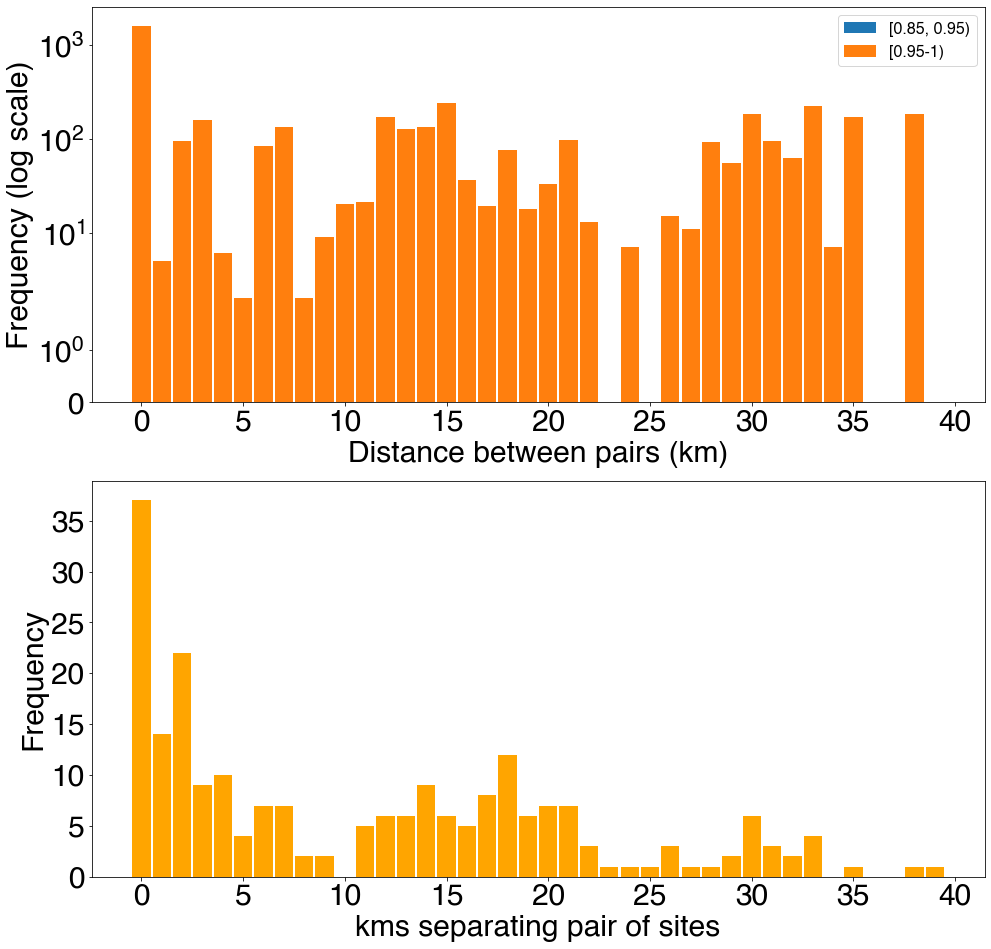

In [28]:
#distancia_genetica_corregida(fam1[1], fam2[1], distribution["all"], N_mam=nm)
dfPC2018=df[df.Cluster=='PC2018'].sort_values(aleles)
dfPC2017=df[df.Cluster=='PC2017'].sort_values(aleles)

f=plt.figure(figsize=(16,16))
ax=plt.subplot(int(str("211")))    

k=1

for op in [0.85, 0.95]:
    sitios=list(set(dfPC2018.Site))
    j=0
    gemels=[]
    while j<len(dfPC2018):
            i=j+1
            flag=len(aleles)
            while flag==len(aleles) and i<len(dfPC2018):
                flag=0
                while flag<len(aleles) and dfPC2018.iloc[j][aleles[flag]]==dfPC2018.iloc[i][aleles[flag]] : flag+=1
                if flag==len(aleles):
                    if True or distancia_genetica_corregida(dfPC2018.iloc[j], dfPC2018.iloc[i], distribution["all"], N_mam=750)>=op:
                        gemels.append(([dfPC2018.iloc[j]["Site"], 
                                                      dfPC2018.iloc[i]["Site"]], 2018))
                i+=1
            j+=1

    while j<len(dfPC2017):
            i=j+1
            flag=len(aleles)
            while flag==len(aleles) and i<len(dfPC2017):
                flag=0


                while flag<len(aleles) and dfPC2017.iloc[j][aleles[flag]]==dfPC2017.iloc[i][aleles[flag]] : flag+=1
                if flag==len(aleles):
                    if True or distancia_genetica_corregida(dfPC2017.iloc[j], dfPC2017.iloc[i], distribution2017["all"], N_mam=475)>=op:
                        gemels.append(([dfPC2017.iloc[j]["Site"], 
                                                      dfPC2017.iloc[i]["Site"]], 2017))
                i+=1
            j+=1


    print("Len gemels:"+str(len(gemels)))

    dict_visitas={}
    for i in range(50):
            dict_visitas[i]=0

    a=0


    for g in gemels:
        k=g[0][0]
        u=g[0][1]
        if g[1]==2018: 
            l1=utm.from_latlon(coordenadas[k][0], coordenadas[k][1])
            l2=utm.from_latlon(coordenadas[u][0], coordenadas[u][1])
        else:
            if g[1]!=2017: print(7/0)
            l1=utm.from_latlon(coordenadas2017[k][0], coordenadas2017[k][1])
            l2=utm.from_latlon(coordenadas2017[u][0], coordenadas2017[u][1])

        dist=euclidean_dist((l1[0], l1[1]), (l2[0], l2[1]))/1000

        dict_visitas[int(round(dist))]+=1

    if op==0.85: plt.bar([d for d in range(0, 40)], [dict_visitas[d] for d in range(0,40)],  width=0.9, label="[0.85, 0.95)")
    else: plt.bar([d for d in range(0, 40)], [dict_visitas[d] for d in range(0,40)],  width=0.9, label="[0.95-1)")
    plt.yscale("log")




plt.title("")

ax.set_yscale('symlog')

ax.legend()

plt.subplot(int(str("212")))    
plt.bar([d for d in range(0, 40)], [dict_nums[d] for d in range(0,40)], width=0.9, color="orange")
plt.title("")
#plt.yscale("log")
    
plt.subplot(int(str("211")))  
plt.xlabel("Distance between pairs (km)", size=30)
plt.xticks(size=30)
plt.yticks(size=30)
plt.ylabel("Frequency (log scale)", size=30)

plt.subplot(int(str("212")))  
plt.xlabel("kms separating pair of sites", size=30)
plt.xticks(size=30)
plt.yticks(size=30)
plt.ylabel("Frequency", size=30)



plt.show()
f.savefig("twins.pdf")
f.savefig("twins.png")


In [29]:
3

3

In [40]:
df.head()

,Collection site,name0,name1,Al1,Al2,Al3,Al4,Al5,Al6,Al7,Old prob,Cluster,Site
0,UNISYD,104.2RGSYD8,104.2RG,157,143,175,154,206,233,137,0.950167,PC2018,Camperdown
1,UNISYD,68.2RGSYD8,68.2RG,159,152,184,152,201,231,137,0.950237,PC2018,Camperdown
2,1 Oberon Cresc,47.8RGSYD8,47.8RG,166,143,175,150,203,235,137,0.950737,PC2018,Gordon
3,92 Griffiths St. balgowlah,51.18RGSYD8,51.18RG,170,143,187,152,203,235,137,0.951578,PC2018,Balgowlah
4,Kate´s place Unit 6 2-4 Wood st. Manley,97.19RGSYD8,97.19RG,172,143,184,152,206,235,149,0.951590,PC2018,Manley


Len gemels:325
0.9206349206349206
Len gemels:200
0.9206349206349206


/Users/Bernardo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/Bernardo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


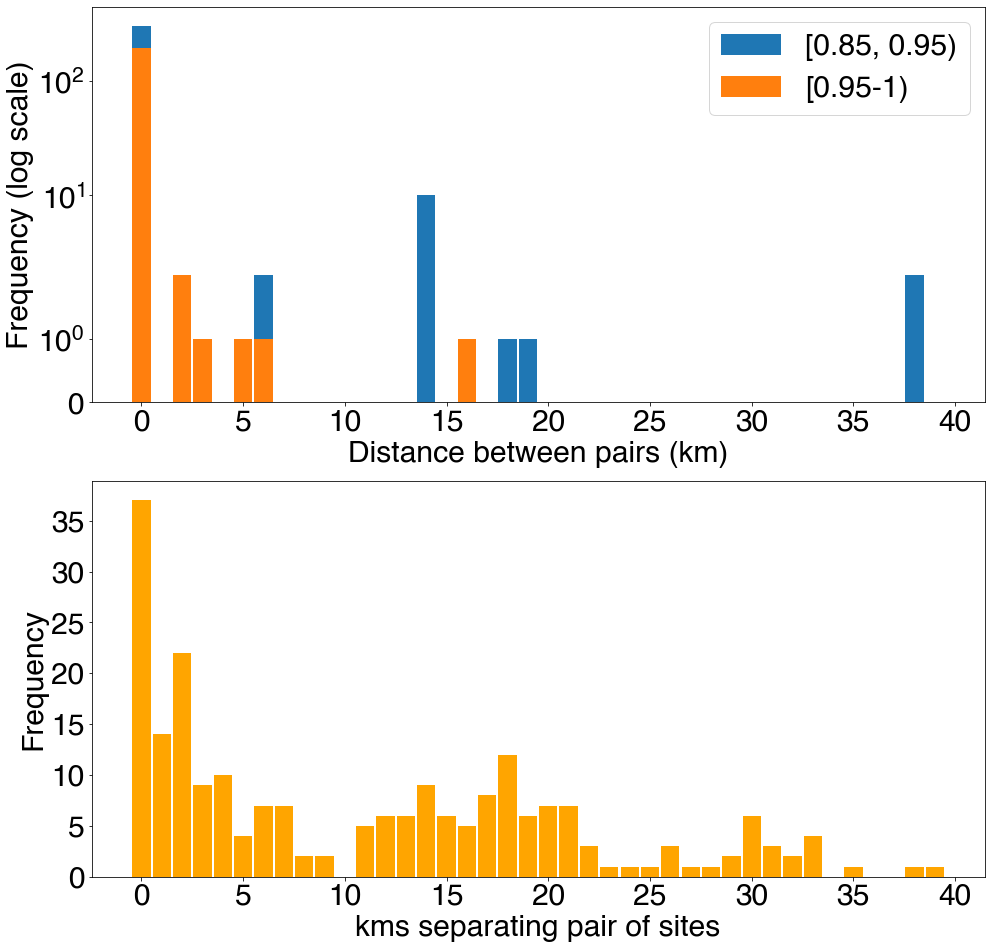

In [44]:
dfPC2018=df[df.Cluster=='PC2018'].sort_values(aleles)
dfPC2017=df[df.Cluster=='PC2017'].sort_values(aleles)

f=plt.figure(figsize=(16,16))
ax=plt.subplot(int(str("211")))    
names_gemels=[]
k=1

for op in [0.85, 0.95]:
    sitios=list(set(dfPC2018.Site))
    j=0
    gemels=[]
    while j<len(dfPC2018):
            if dfPC2018.iloc[j]["Old prob"]>=op:
                i=j+1
                flag=len(aleles)
                while flag==len(aleles) and i<len(dfPC2018):
                    flag=0
                    while flag<len(aleles) and dfPC2018.iloc[j][aleles[flag]]==dfPC2018.iloc[i][aleles[flag]] : flag+=1
                    if flag==len(aleles):
                        gemels.append(([dfPC2018.iloc[j]["Site"], 
                                                      dfPC2018.iloc[i]["Site"]], 2018))
                        names_gemels.append((dfPC2018.iloc[j]["name0"], 
                                                      dfPC2018.iloc[i]["name0"], 2018))
                    i+=1
            j+=1

    while j<len(dfPC2017):
            if dfPC2017.iloc[j]["Old prob"]>=op:
                i=j+1
                flag=len(aleles)
                while flag==len(aleles) and i<len(dfPC2017):
                    flag=0
                    while flag<len(aleles) and dfPC2017.iloc[j][aleles[flag]]==dfPC2017.iloc[i][aleles[flag]] : flag+=1
                    if flag==len(aleles):
                        gemels.append(([dfPC2017.iloc[j]["Site"], 
                                                      dfPC2017.iloc[i]["Site"]], 2017))
                        names_gemels.append((dfPC2017.iloc[j]["name0"], 
                                                      dfPC2017.iloc[i]["name0"], 2018))
                    i+=1
            j+=1


    print("Len gemels:"+str(len(gemels)))

    dict_visitas={}
    for i in range(50):
            dict_visitas[i]=0

    a=0

    all_distances=[]
    for g  in gemels:
        k=g[0][0]
        u=g[0][1]
        if g[1]==2018: 
            l1=utm.from_latlon(coordenadas[k][0], coordenadas[k][1])
            l2=utm.from_latlon(coordenadas[u][0], coordenadas[u][1])
        else:
            if g[1]!=2017: print(7/0)
            l1=utm.from_latlon(coordenadas2017[k][0], coordenadas2017[k][1])
            l2=utm.from_latlon(coordenadas2017[u][0], coordenadas2017[u][1])

        dist=euclidean_dist((l1[0], l1[1]), (l2[0], l2[1]))/1000
        all_distances.append(dist)
        dict_visitas[int(round(dist))]+=1
    
    if op==0.85: plt.bar([d for d in range(0, 40)], [dict_visitas[d] for d in range(0,40)],  width=0.9, label="[0.85, 0.95)")
    else: plt.bar([d for d in range(0, 40)], [dict_visitas[d] for d in range(0,40)],  width=0.9, label="[0.95-1)")
    plt.yscale("log")
    with open("twins_file_prob_"+str(op)+".csv", "w") as fil:
        fil.write("distance, name1, name2, year\n")
        nlis=[str(i)+", "+str(j)[1:-1] for i,j in zip(all_distances, names_gemels)]
        fil.write("\n".join(nlis))
    
    print(tot6km/totot)




plt.title("")

ax.set_yscale('symlog')

ax.legend(prop={'size': 30})

plt.subplot(int(str("212")))    
plt.bar([d for d in range(0, 40)], [dict_nums[d] for d in range(0,40)], width=0.9, color="orange")
plt.title("")
#plt.yscale("log")
    
plt.subplot(int(str("211")))  
plt.xlabel("Distance between pairs (km)", size=30)
plt.xticks(size=30)
plt.yticks(size=30)
plt.ylabel("Frequency (log scale)", size=30)

plt.subplot(int(str("212")))  
plt.xlabel("kms separating pair of sites", size=30)
plt.xticks(size=30)
plt.yticks(size=30)
plt.ylabel("Frequency", size=30)



plt.show()
f.savefig("twins.pdf")
f.savefig("twins.png")


Prior 570 families


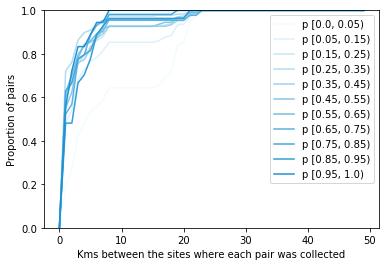

In [101]:
uu="all"
kk=570
print("Prior "+str(kk)+" families")
df_pares_abejas=pd.DataFrame({"Distancia":df2017[uu],
             "Similitud_genetica_4":dg42017[uu][kk]})
dicton_final2017=final_plot(df_pares_abejas)

In [129]:
import random
d2=0
connection=get_connection()

with connection.cursor() as cursor:
    sql="select * from tasks_abejas where task_params like \"%\\\"year\\\":2017%\" and task_completed>0"
    cursor.execute(sql)
    res=cursor.fetchall()
connection.close()

In [130]:
finished_2017=[r["task_id"] for r in res]
if True:
    connection=get_connection()
    kk=300
    with connection.cursor() as cursor:
        for k in range(0,101, 10):
            sql="update abejas_curvas2 set "
            for i in range(50):
                sql+="int_"+str(i)+"= int_"+str(i)+" - "+str(dicton_final2017[k][1][i])
                if i<=48:
                    sql+=", "
            sql+=" where k="+str(k)+" and task_id in ("+", ".join([str(y) for y in finished_2017])+");"
            cursor.execute(sql)
    connection.commit()
    connection.close()

In [131]:
def get_s2017_curvas():
    import random
    d2=0
    connection=get_connection()

    with connection.cursor() as cursor:
        sql="select * from tasks_abejas where task_params like \"%\\\"year\\\":2017%\" and task_completed>0"
        cursor.execute(sql)
        res=cursor.fetchall()
    connection.close()

    finished_2017=[r["task_id"] for r in res]
    
    connection=get_connection()

    with connection.cursor() as cursor:
        sql="select * from abejas_curvas2 where task_id in ("+", ".join([str(y) for y in finished_2017])+");"
        cursor.execute(sql)
        abejas_curvas_2=cursor.fetchall()
    connection.close()

    df_abejas_curvas_2=pd.DataFrame(abejas_curvas_2)

    for k in range(50):
        print(k, end="    \r")
        df_abejas_curvas_2["Int_"+str(k)+"_abs"]=abs(df_abejas_curvas_2["Int_"+str(k)])
        if k<49:
            df_abejas_curvas_2["chs_"+str(k)]=((df_abejas_curvas_2["Int_"+str(k)])*(df_abejas_curvas_2["Int_"+str(k+1)])<0)


    for k in range(50):
        print(k, end="    \r")
        if k==0:
            df_abejas_curvas_2["Int_"+str(k)+"_abs_adj"]=df_abejas_curvas_2["Int_"+str(k)+"_abs"]/2-(0.25)*df_abejas_curvas_2["chs_"+str(k)]*df_abejas_curvas_2["Int_"+str(k)+"_abs"]
        elif k<49:
            df_abejas_curvas_2["Int_"+str(k)+"_abs_adj"]=df_abejas_curvas_2["Int_"+str(k)+"_abs"]-(0.25)*df_abejas_curvas_2["chs_"+str(k)]*df_abejas_curvas_2["Int_"+str(k)+"_abs"]-(0.25)*df_abejas_curvas_2["chs_"+str(k-1)]*df_abejas_curvas_2["Int_"+str(k)+"_abs"]
        else:
            df_abejas_curvas_2["Int_"+str(k)+"_abs_adj"]=(df_abejas_curvas_2["Int_"+str(k)+"_abs"]/2)-(0.25)*df_abejas_curvas_2["chs_"+str(k-1)]*df_abejas_curvas_2["Int_"+str(k)+"_abs"]

    df_abejas_curvas_2["int_mean"]=df_abejas_curvas_2[["Int_"+str(j)+"_abs_adj" for j in range(50)]].mean(1)

    np.sum(np.isnan(df_abejas_curvas_2["int_mean"]))

    from scipy.stats.mstats import gmean

    df_abejas_curvas_2=df_abejas_curvas_2[df_abejas_curvas_2["k"]<65][["int_mean", "task_id"]].groupby("task_id").agg(gmean)

    df_abejas_curvas_2=df_abejas_curvas_2.join(pd.DataFrame(res).set_index("task_id")[["task_params"]])
    
    df_abejas_curvas_2["bootstrap"]=[eval(aa)["bootstrap"] for aa in df_abejas_curvas_2["task_params"]]
    df_abejas_curvas_2["N_mam"]=[eval(aa)["N_mam"] for aa in df_abejas_curvas_2["task_params"]]
    df_abejas_curvas_2["urban"]=[eval(aa)["urban"] for aa in df_abejas_curvas_2["task_params"]]
    df_abejas_curvas_2["rural"]=[eval(aa)["rural"] for aa in df_abejas_curvas_2["task_params"]]
    df_abejas_curvas_2["lambda"]=[eval(aa)["params"]["lambd"] for aa in df_abejas_curvas_2["task_params"]]
    df_abejas_curvas_2["exp_mean"]=1/df_abejas_curvas_2["lambda"]


    return df_abejas_curvas_2

In [132]:
df_final_hoy=get_s2017_curvas()

300


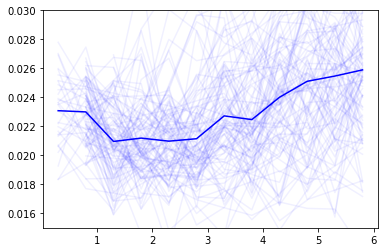

In [135]:
print(kk)
cropp=df_final_hoy
for boot in range(100):

    c2=cropp[cropp["bootstrap"]==boot]
    plt.plot(c2["exp_mean"], c2["int_mean"], color="blue", alpha=0.06)

#plt.ylim([0,1000000])

c2=cropp.groupby(["exp_mean"]).mean().reset_index()

plt.plot(c2["exp_mean"], c2["int_mean"], color="blue")
plt.ylim([0.015, 0.030])
plt.show()



all


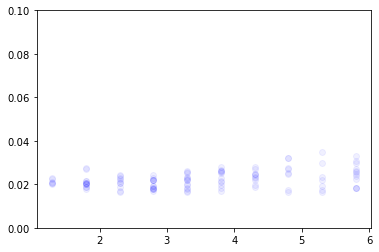

In [121]:
print(kk)
cropp=df_final_hoy

plt.scatter(cropp["exp_mean"], cropp["int_mean"], color="blue", alpha=0.06)

plt.ylim([0,0.1])
plt.show()



In [118]:
cropp

,int_mean,task_params,bootstrap,N_mam,urban,rural,lambda,exp_mean
task_id,,,,,,,,
114592,0.020651,"{ ""num_abejas"":3000, ""bootstrap"":19, ""randomfu...",19,570,True,True,0.769231,1.3
114622,0.022488,"{ ""num_abejas"":3000, ""bootstrap"":49, ""randomfu...",49,570,True,True,0.769231,1.3
114637,0.020399,"{ ""num_abejas"":3000, ""bootstrap"":64, ""randomfu...",64,570,True,True,0.769231,1.3
114652,0.021064,"{ ""num_abejas"":3000, ""bootstrap"":79, ""randomfu...",79,570,True,True,0.769231,1.3
114661,0.023078,"{ ""num_abejas"":3000, ""bootstrap"":88, ""randomfu...",88,570,True,True,0.769231,1.3
114672,0.020241,"{ ""num_abejas"":3000, ""bootstrap"":99, ""randomfu...",99,570,True,True,0.769231,1.3
114683,0.020683,"{ ""num_abejas"":3000, ""bootstrap"":10, ""randomfu...",10,570,True,True,0.555556,1.8
114689,0.895622,"{ ""num_abejas"":3000, ""bootstrap"":16, ""randomfu...",16,570,True,True,0.555556,1.8
114693,0.020337,"{ ""num_abejas"":3000, ""bootstrap"":20, ""randomfu...",20,570,True,True,0.555556,1.8
